In [1]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm

---

In [30]:
ard_not_adv = pd.read_csv('ard_not_adv.csv', skiprows = 0)
# ard_not_adv.columns = ['indx','level_0','index','amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id','glat','glon','amf_sn']

In [31]:
ard_not_adv

,Unnamed: 0,Unnamed: 0.1,indx,level_0,index,amf_no,amf_ra,amf_dec,amf_z,amf_lk,...,amf_str_rh,bax_id,mcxc_id,red_id,whl_id,glat,glon,amf_sn,intensity100,intensity857
0,0,0,0,0,0.0,5.0,260.6324,32.1398,0.2252,222.1219,...,35.0001,ABELL2261,J1722.4+3208,RMJ172227.2+320757.2,J172227.2+320757,31.846666,55.602221,24.655148,-0.000048,1.978746
1,1,1,1,1,2.0,7.0,250.1485,46.6917,0.2248,225.9874,...,36.0001,ABELL2219,J1640.3+4642,RMJ164019.8+464241.5,J164019.8+464242,41.429880,72.599428,44.674799,-0.000269,1.196847
2,2,0,0,0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0,0,0,0,0.000000,0.000000,0.000000,0.000175,1.783996
3,3,3,3,3,5.0,10.0,203.1873,50.5346,0.3110,164.8704,...,31.0001,ABELL1758A,J1332.7+5032,RMJ133238.4+503336.0,J133252.1+503134,65.305106,107.103759,25.696075,-0.000124,1.019871
4,4,4,4,4,7.0,12.0,350.2432,29.2029,0.5231,165.0015,...,69.0001,-9999,-9999,RMJ232104.1+291134.5,J232104.1+291134,-29.646780,100.211077,13.793623,0.000047,4.913466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21533,21533,21533,21533,21533,31526.0,54265.0,117.7965,28.4314,0.4498,21.3133,...,32.1136,-9999,-9999,-9999,J075110.0+282537,24.760679,192.272829,0.235375,-0.000085,1.742793
21534,21534,21534,21534,21534,31527.0,54266.0,10.2234,16.4729,0.3325,7.5789,...,75.0967,-9999,-9999,-9999,J004043.6+162754,-46.323866,119.270217,1.128670,-0.000071,1.821485
21535,21535,21535,21535,21535,31529.0,54272.0,332.5373,16.8053,0.2720,19.0528,...,73.0856,-9999,-9999,-9999,J221009.3+165449,-31.180104,76.542726,0.327218,-0.000112,2.181500
21536,21536,21536,21536,21536,31530.0,54273.0,321.0614,-5.5885,0.4036,7.3319,...,85.1216,-9999,-9999,-9999,J212412.8-053647,-36.312474,46.861993,0.906488,0.000283,3.162386


In [3]:
ard_not_adv[ard_not_adv.amf_sn=='--']=0
ard_not_adv['amf_sn'] = pd.to_numeric(ard_not_adv['amf_sn'])

In [4]:
intensity = pd.read_csv('intensity.csv',skiprows=0)

In [5]:
ard_not_adv['intensity100']=intensity['intensity']

---

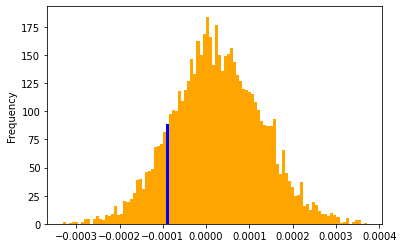

In [7]:
s = ard_not_adv[(ard_not_adv.intensity100!=0) & (ard_not_adv.glat<0)]['intensity100']
p = s.plot(kind='hist', bins=100, color='orange')
p.patches[34].set_color('b')

plt.show()

---

In [8]:
# mask = hp.read_map('../../project1_PB/fitsData/HFI_PCCS_SZ-selfunc-inter-cosmo_2.02.fits')

# # Get the nside and number of pixels in your map
# nside = hp.get_nside(mask)
# npix = hp.nside2npix(nside)
# maskedPixels, = np.where(mask == 0)

# # Use pix2ang to get the (l, b) coordinates for each pixel
# glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
# maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
# maskedArray = maskedArray[(maskedArray.glat > 12)|((maskedArray.glat<-12) & (maskedArray.glon<180))].reset_index()

In [9]:
# intersec = pd.DataFrame()
# intersec = pd.DataFrame(data=ard_not_adv, columns=ard_not_adv.columns)

In [10]:
# intersec = intersec.iloc[0:0]

# for i in tqdm(range(ard_not_adv.shape[0])):
#     matches = maskedArray.loc[(maskedArray['glat'].sub(ard_not_adv.iloc[i]['glat']).abs()<1) & (maskedArray['glon'].sub(ard_not_adv.iloc[i]['glon']).abs()<1)]
#     if len(matches)!=0:     
#         intersec.loc[len(intersec)] = ard_not_adv.iloc[i]

# print(len(intersec))
# print(len(intersec[intersec.amf_rh>50]))

In [11]:
# hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
# # hp.visufunc.projscatter(ard_not_adv['glon'],ard_not_adv['glat'],c='b',lonlat=True,s=10)
# hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)
# hp.visufunc.projscatter(intersec.glon,intersec.glat,c='k',lonlat=True,s=10)

---

In [12]:
# plt.scatter(ard_not_adv[ard_not_adv.amf_rh>1]['amf_sn'],ard_not_adv[ard_not_adv.amf_rh>1]['amf_rh'],s=0.1)
# plt.xlabel('sn')
# plt.ylabel('richness')

In [13]:
# plt.scatter(ard_not_adv['amf_sn'],ard_not_adv['intensity'],s=0.1)
# plt.xlabel('sn')
# plt.ylabel('intensity')

---

In [14]:
# actmap = enmap.read_map("act_dr5.01_s08s18_AA_f090_daynight_map.fits")
ros = hp.read_map("rass_healpix_countsec.fits")
pl = hp.read_map("HFI_SkyMap_857-field-Int_2048_R3.00_full.fits")
mask = hp.read_map("mask_comprass.fits")

pl[pl<-1e23]=0
ros[ros<-1e23]=0

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [15]:
# masked_ros = []
# for i in tqdm(range(len(mask))):
#     masked_ros.append(0)
#     if mask[i]:
#         masked_ros[i]=ros[i]
        
# masked_ros = np.array(masked_ros)

In [16]:
shape,wcs = enmap.fullsky_geometry(res=5.0 * utils.arcmin,proj='car')

In [17]:
map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)
# map_pix = reproject.enmap_from_healpix(ros,shape=shape,wcs=wcs)

Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


---

In [24]:
stamps90 = []

ras  = ard_not_adv['amf_ra']
decs = ard_not_adv['amf_dec']
#ras = ard_not_adv[(ard_not_adv.amf_rh<25) & (ard_not_adv.amf_rh>0)]['amf_ra'].reset_index(drop=True)
#decs = ard_not_adv[(ard_not_adv.amf_rh<25) & (ard_not_adv.amf_rh>0)]['amf_dec'].reset_index(drop=True)

N = len(ras)
# N=200
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

for i in tqdm(range(N)):
#     print(decs[i],ras[i])
    stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=3*utils.arcmin)
#     stamp_1arc = reproject.thumbnails(planck_pix,coords = np.deg2rad([decs[i], ras[i]]),r=5*utils.arcmin)
    
    if stamp is None:
        continue
    elif stamp[0][0][0]==0.0:
        continue
        
    stamps90.append(sum(sum(stamp[0]))/9)
    
    stack_CMB_kSZ += stamp 
    c += 1
#     plt.imshow(stamp[0])

#     print("SUM:", sum(sum(stamp[0])))
#     plt.show()

100%|██████████| 21538/21538 [02:10<00:00, 164.77it/s]


In [27]:
ard_not_adv['intensity857']=stamps90
len(stamps90)

21538

In [29]:
ard_not_adv.to_csv("ard_not_adv.csv")

---

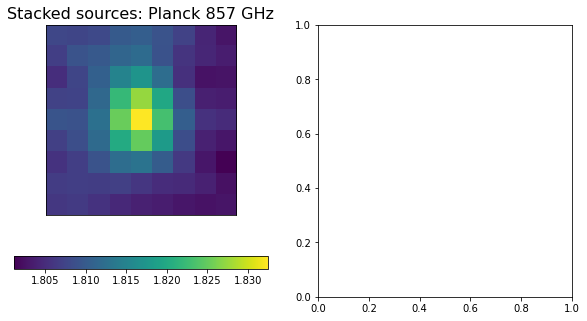

<Figure size 432x288 with 0 Axes>

In [22]:
    
# Normalize the stamps
stack_CMB_kSZ /= c
stack_CMB_kSZ_deproject /= c

# Now we can plot both of these and compare
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

f, ax = plt.subplots(1,2, figsize=(10, 5))

f1 = ax[0].imshow(stack_CMB_kSZ[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# scalebar = AnchoredSizeBar(ax[0].transData,
#                            19.8, '', 'center left', 
#                            pad=0.1,
#                            color='white',
#                            frameon=False,
#                            size_vertical=0.1)
# ax[0].add_artist(scalebar)
# ax[0].text(1,22,"5 arcmin",color='white')

ax[0].set_title("Stacked sources: Planck 857 GHz", fontsize = 16)
plt.colorbar(mappable = f1, ax = ax[0],orientation='horizontal')

plt.show()
plt.savefig("pl_857.png")

---